In [1]:
#!pip install pandas
#!pip install numpy
#!pip install seaborn
#!pip install matplotlib

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

# Optimiza los gráficos para pantalla retina
%config InlineBackend.figure_format = 'retina'
# Por defecto usamos el backend inline
%matplotlib inline

# La libreta ocupa así el 95% de la pantalla
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

1.- Carga de datos

In [20]:
df_dosificaciones = pd.read_csv('datos/datos.csv', \
                    sep=',', na_values='\\N', index_col='codigo', \
                    parse_dates=['fecha_inicio', 'fecha_fin'])
df_dosificaciones.head(5)

,fecha_inicio,fecha_fin,cantidad_solicitada,cantidad_dosificada,mezcla,pesada,peso_inicial,manual,materia_origen,materia_destino,id_silo,tipo_materia,tipo_destino,densidad,tam_mezcla,desviacion
codigo,,,,,,,,,,,,,,,,
7,2013-08-14 16:51:48,2013-08-14 16:52:39,235.026497,236.500003,1,0,0.000000,0,13,66,90,Prima,Premezcla,1.0,500,-1.473506
8,2013-08-14 16:55:18,2013-08-14 16:58:45,2.499750,2.699997,1,0,237.099994,0,16,66,9,Prima,Premezcla,1.0,500,-0.200247
9,2013-08-14 16:59:09,2013-08-14 17:00:46,7.499250,7.399994,1,0,239.599994,0,51,66,9,Prima,Premezcla,1.0,500,0.099256
10,2013-08-14 17:01:22,2013-08-14 17:03:32,32.496750,33.199997,1,0,247.800006,0,22,66,9,Prima,Premezcla,1.0,500,-0.703247
11,2013-08-14 17:03:40,2013-08-14 17:05:48,37.496250,38.600006,1,0,280.999988,0,12,66,9,Prima,Premezcla,1.0,500,-1.103756


2.- Exploracion de datos

In [4]:
df_dosificaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2220628 entries, 7 to 3169926
Data columns (total 16 columns):
 #   Column               Dtype         
---  ------               -----         
 0   fecha_inicio         datetime64[ns]
 1   fecha_fin            datetime64[ns]
 2   cantidad_solicitada  float64       
 3   cantidad_dosificada  float64       
 4   mezcla               int64         
 5   pesada               int64         
 6   peso_inicial         float64       
 7   manual               int64         
 8   materia_origen       int64         
 9   materia_destino      int64         
 10  id_silo              int64         
 11  tipo_materia         object        
 12  tipo_destino         object        
 13  densidad             float64       
 14  tam_mezcla           int64         
 15  desviacion           float64       
dtypes: datetime64[ns](2), float64(5), int64(7), object(2)
memory usage: 288.0+ MB


In [5]:
#df_dosificaciones = df_dosificaciones.replace('\\N', np.nan)

In [6]:
#df_dosificaciones['peso_inicial'] = df_dosificaciones['peso_inicial'].fillna(0)

In [5]:
df_dosificaciones.isnull().sum()

fecha_inicio               0
fecha_fin                 19
cantidad_solicitada        0
cantidad_dosificada        0
mezcla                     0
pesada                     0
peso_inicial           46989
manual                     0
materia_origen             0
materia_destino            0
id_silo                    0
tipo_materia               0
tipo_destino               0
densidad                   0
tam_mezcla                 0
desviacion                 0
dtype: int64

In [8]:
df_dosificaciones = df_dosificaciones.dropna()

In [9]:
df_dosificaciones.isnull().sum()

fecha_inicio           0
fecha_fin              0
cantidad_solicitada    0
cantidad_dosificada    0
mezcla                 0
pesada                 0
peso_inicial           0
manual                 0
materia_origen         0
materia_destino        0
id_silo                0
tipo_materia           0
tipo_destino           0
densidad               0
tam_mezcla             0
desviacion             0
dtype: int64

In [10]:
for col in df_dosificaciones:
    if (df_dosificaciones[col].nunique() < 5):
        print(col + ": ")
        print(df_dosificaciones[col].unique())

pesada: 
[0 1]
manual: 
[0 1]
tipo_materia: 
['Prima']
tipo_destino: 
['Premezcla' 'Formula']
densidad: 
[1.    0.85  1.226 1.45 ]


In [12]:
df_dosificaciones = df_dosificaciones[df_dosificaciones['manual'] == 0]

In [13]:
for col in df_dosificaciones:
    if (df_dosificaciones[col].nunique() < 5):
        print(col + ": ")
        print(df_dosificaciones[col].unique())

pesada: 
[0 1]
manual: 
[0]
tipo_materia: 
['Prima']
tipo_destino: 
['Premezcla' 'Formula']
densidad: 
[1.    0.85  1.226 1.45 ]


In [14]:
df_dosificaciones[['cantidad_solicitada','cantidad_dosificada', \
                   'peso_inicial','tam_mezcla', 'desviacion']].describe()

,cantidad_solicitada,cantidad_dosificada,peso_inicial,tam_mezcla,desviacion
count,2.173597e+06,2.173597e+06,2.173597e+06,2.173597e+06,2.173597e+06
mean,1.551270e+02,1.549170e+02,3.572072e+02,3.830281e+03,2.099743e-01
std,4.110575e+02,4.106909e+02,8.677987e+02,7.734728e+02,1.728964e+01
min,0.000000e+00,0.000000e+00,-6.400000e+01,4.000000e+02,-8.760000e+02
25%,4.604878e+00,4.699997e+00,0.000000e+00,4.000000e+03,-1.005216e-01
50%,1.195493e+01,1.180000e+01,2.200000e+01,4.000000e+03,-3.051758e-06
75%,3.564392e+01,3.476250e+01,7.323750e+01,4.020000e+03,9.999919e-02
max,8.667933e+03,5.777000e+03,6.429000e+03,4.500000e+03,7.963000e+03


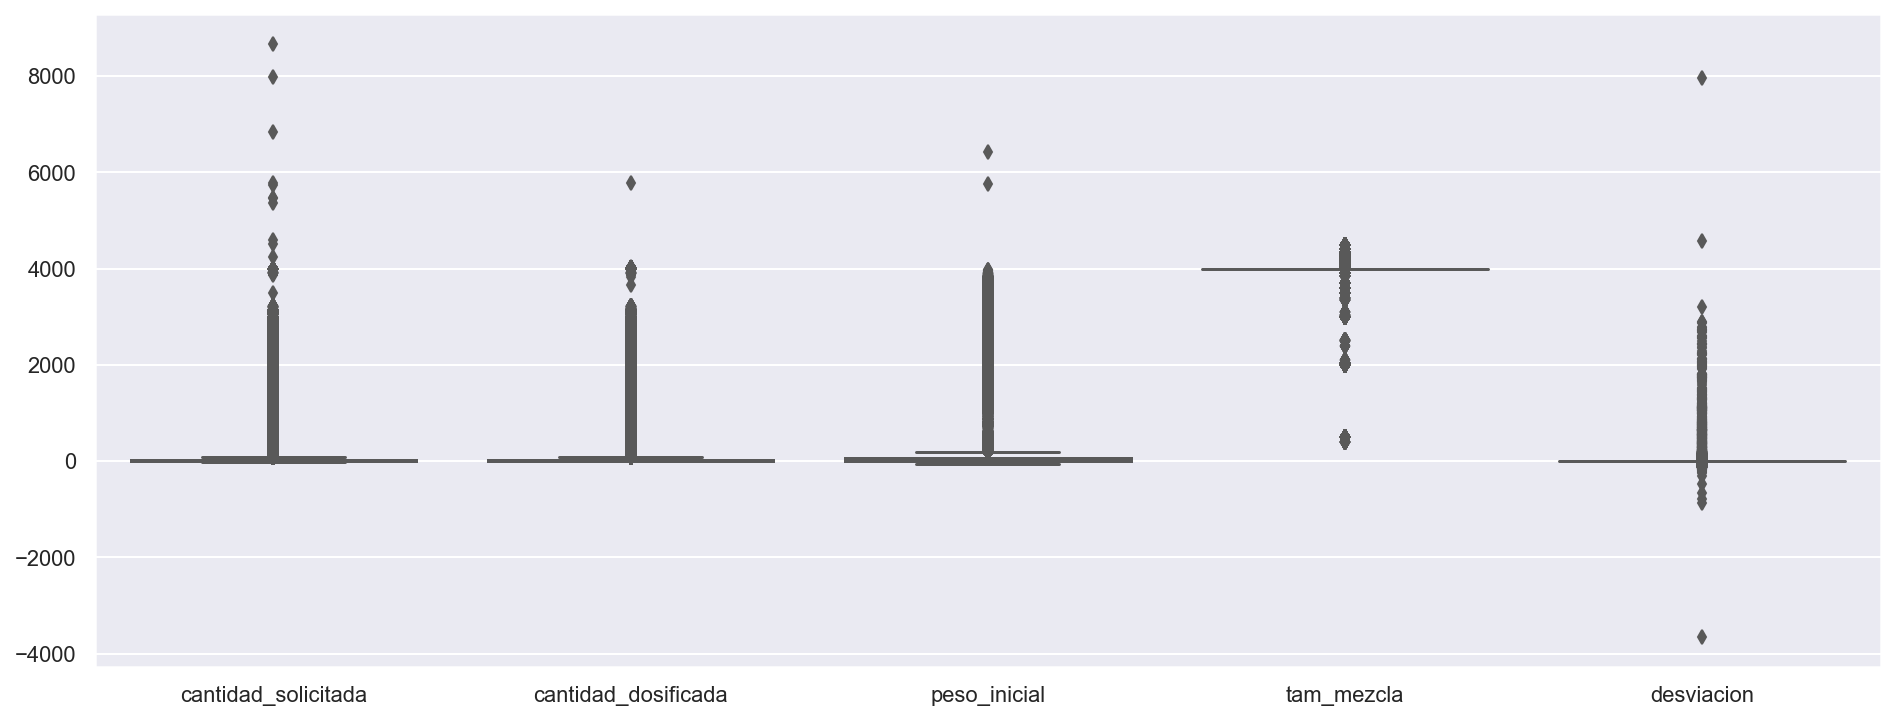

In [21]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_dosificaciones[['cantidad_solicitada','cantidad_dosificada','peso_inicial','tam_mezcla', 'desviacion']], palette="Set2")

plt.show()

In [22]:
df_dosificaciones = df_dosificaciones[(df_dosificaciones['cantidad_solicitada'] > 0) &
                  (df_dosificaciones['cantidad_solicitada'] < 2500) &
                  (df_dosificaciones['cantidad_dosificada'] > 1) &
                  (df_dosificaciones['cantidad_dosificada'] < 3000) &
                  (df_dosificaciones['desviacion'] > -100) &
                  (df_dosificaciones['desviacion'] < 100) &
                  (df_dosificaciones['peso_inicial'] < 3500)]

In [23]:
df_dosificaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047815 entries, 7 to 3169927
Data columns (total 16 columns):
 #   Column               Dtype         
---  ------               -----         
 0   fecha_inicio         datetime64[ns]
 1   fecha_fin            datetime64[ns]
 2   cantidad_solicitada  float64       
 3   cantidad_dosificada  float64       
 4   mezcla               int64         
 5   pesada               int64         
 6   peso_inicial         float64       
 7   manual               int64         
 8   materia_origen       int64         
 9   materia_destino      int64         
 10  id_silo              int64         
 11  tipo_materia         object        
 12  tipo_destino         object        
 13  densidad             float64       
 14  tam_mezcla           int64         
 15  desviacion           float64       
dtypes: datetime64[ns](2), float64(5), int64(7), object(2)
memory usage: 265.6+ MB


In [25]:
columns_delete = ['fecha_fin','cantidad_dosificada','mezcla', \
                  'pesada','manual','densidad','tipo_materia', \
                  'tipo_destino']
df_dosificaciones.drop(columns=columns_delete, inplace=True)

In [26]:
df_dosificaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047815 entries, 7 to 3169927
Data columns (total 8 columns):
 #   Column               Dtype         
---  ------               -----         
 0   fecha_inicio         datetime64[ns]
 1   cantidad_solicitada  float64       
 2   peso_inicial         float64       
 3   materia_origen       int64         
 4   materia_destino      int64         
 5   id_silo              int64         
 6   tam_mezcla           int64         
 7   desviacion           float64       
dtypes: datetime64[ns](1), float64(3), int64(4)
memory usage: 140.6 MB


In [20]:
df_dosificaciones.head(5)

,fecha_inicio,cantidad_solicitada,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,desviacion
codigo,,,,,,,,
7,2013-08-14 16:51:48,235.026497,0.000000,13,66,90,500,-1.473506
8,2013-08-14 16:55:18,2.499750,237.099994,16,66,9,500,-0.200247
9,2013-08-14 16:59:09,7.499250,239.599994,51,66,9,500,0.099256
10,2013-08-14 17:01:22,32.496750,247.800006,22,66,9,500,-0.703247
11,2013-08-14 17:03:40,37.496250,280.999988,12,66,9,500,-1.103756


In [27]:
df_dosificaciones['mes'] = pd.DatetimeIndex(df_dosificaciones['fecha_inicio']).month
df_dosificaciones['dia'] = pd.DatetimeIndex(df_dosificaciones['fecha_inicio']).day
df_dosificaciones['hora'] = pd.DatetimeIndex(df_dosificaciones['fecha_inicio']).hour
df_dosificaciones['dow'] = pd.DatetimeIndex(df_dosificaciones['fecha_inicio']).dayofweek
df_dosificaciones.drop(columns=['fecha_inicio'], inplace=True)

In [28]:
df_dosificaciones.head(5)

,cantidad_solicitada,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,desviacion,mes,dia,hora,dow
codigo,,,,,,,,,,,
7,235.026497,0.000000,13,66,90,500,-1.473506,8,14,16,2
8,2.499750,237.099994,16,66,9,500,-0.200247,8,14,16,2
9,7.499250,239.599994,51,66,9,500,0.099256,8,14,16,2
10,32.496750,247.800006,22,66,9,500,-0.703247,8,14,17,2
11,37.496250,280.999988,12,66,9,500,-1.103756,8,14,17,2


In [23]:
df_dosificaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2084242 entries, 7 to 3169927
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   cantidad_solicitada  float64
 1   peso_inicial         float64
 2   materia_origen       int64  
 3   materia_destino      int64  
 4   id_silo              int64  
 5   tam_mezcla           int64  
 6   desviacion           float64
 7   mes                  int64  
 8   dia                  int64  
 9   hora                 int64  
 10  dow                  int64  
dtypes: float64(3), int64(8)
memory usage: 190.8 MB


In [24]:
df_dosificaciones.corr()

,cantidad_solicitada,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,desviacion,mes,dia,hora,dow
cantidad_solicitada,1.000000,0.262373,0.289309,0.005243,-0.406148,0.054957,-0.018416,-0.001157,0.000472,0.010570,0.005361
peso_inicial,0.262373,1.000000,0.493764,-0.072775,-0.299034,0.010592,0.011344,0.006144,-0.001720,-0.007051,0.005752
materia_origen,0.289309,0.493764,1.000000,-0.015810,-0.087964,0.030967,0.005849,-0.021073,-0.002511,-0.006891,0.001047
materia_destino,0.005243,-0.072775,-0.015810,1.000000,-0.004571,-0.053920,0.000368,-0.014093,-0.005744,0.050789,-0.027293
id_silo,-0.406148,-0.299034,-0.087964,-0.004571,1.000000,0.258826,0.016899,0.001592,0.000289,-0.008690,-0.003859
tam_mezcla,0.054957,0.010592,0.030967,-0.053920,0.258826,1.000000,0.011062,0.018276,-0.010482,-0.044093,0.011996
desviacion,-0.018416,0.011344,0.005849,0.000368,0.016899,0.011062,1.000000,-0.000447,-0.000744,-0.001557,0.002994
mes,-0.001157,0.006144,-0.021073,-0.014093,0.001592,0.018276,-0.000447,1.000000,0.012450,0.057794,0.000670
dia,0.000472,-0.001720,-0.002511,-0.005744,0.000289,-0.010482,-0.000744,0.012450,1.000000,0.004632,0.008192
hora,0.010570,-0.007051,-0.006891,0.050789,-0.008690,-0.044093,-0.001557,0.057794,0.004632,1.000000,0.041040


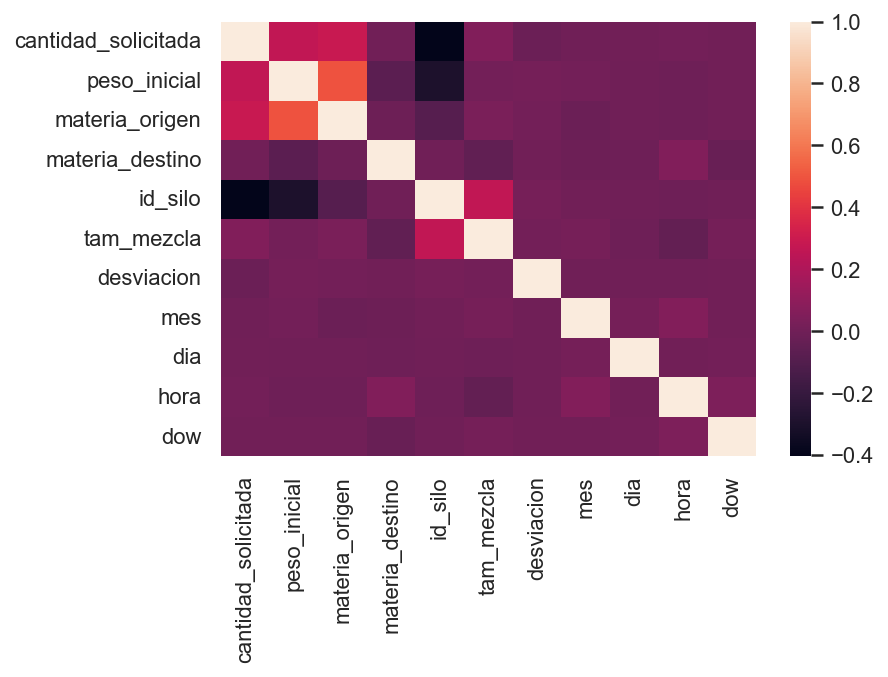

In [25]:
sns.heatmap(df_dosificaciones.corr())
plt.show()

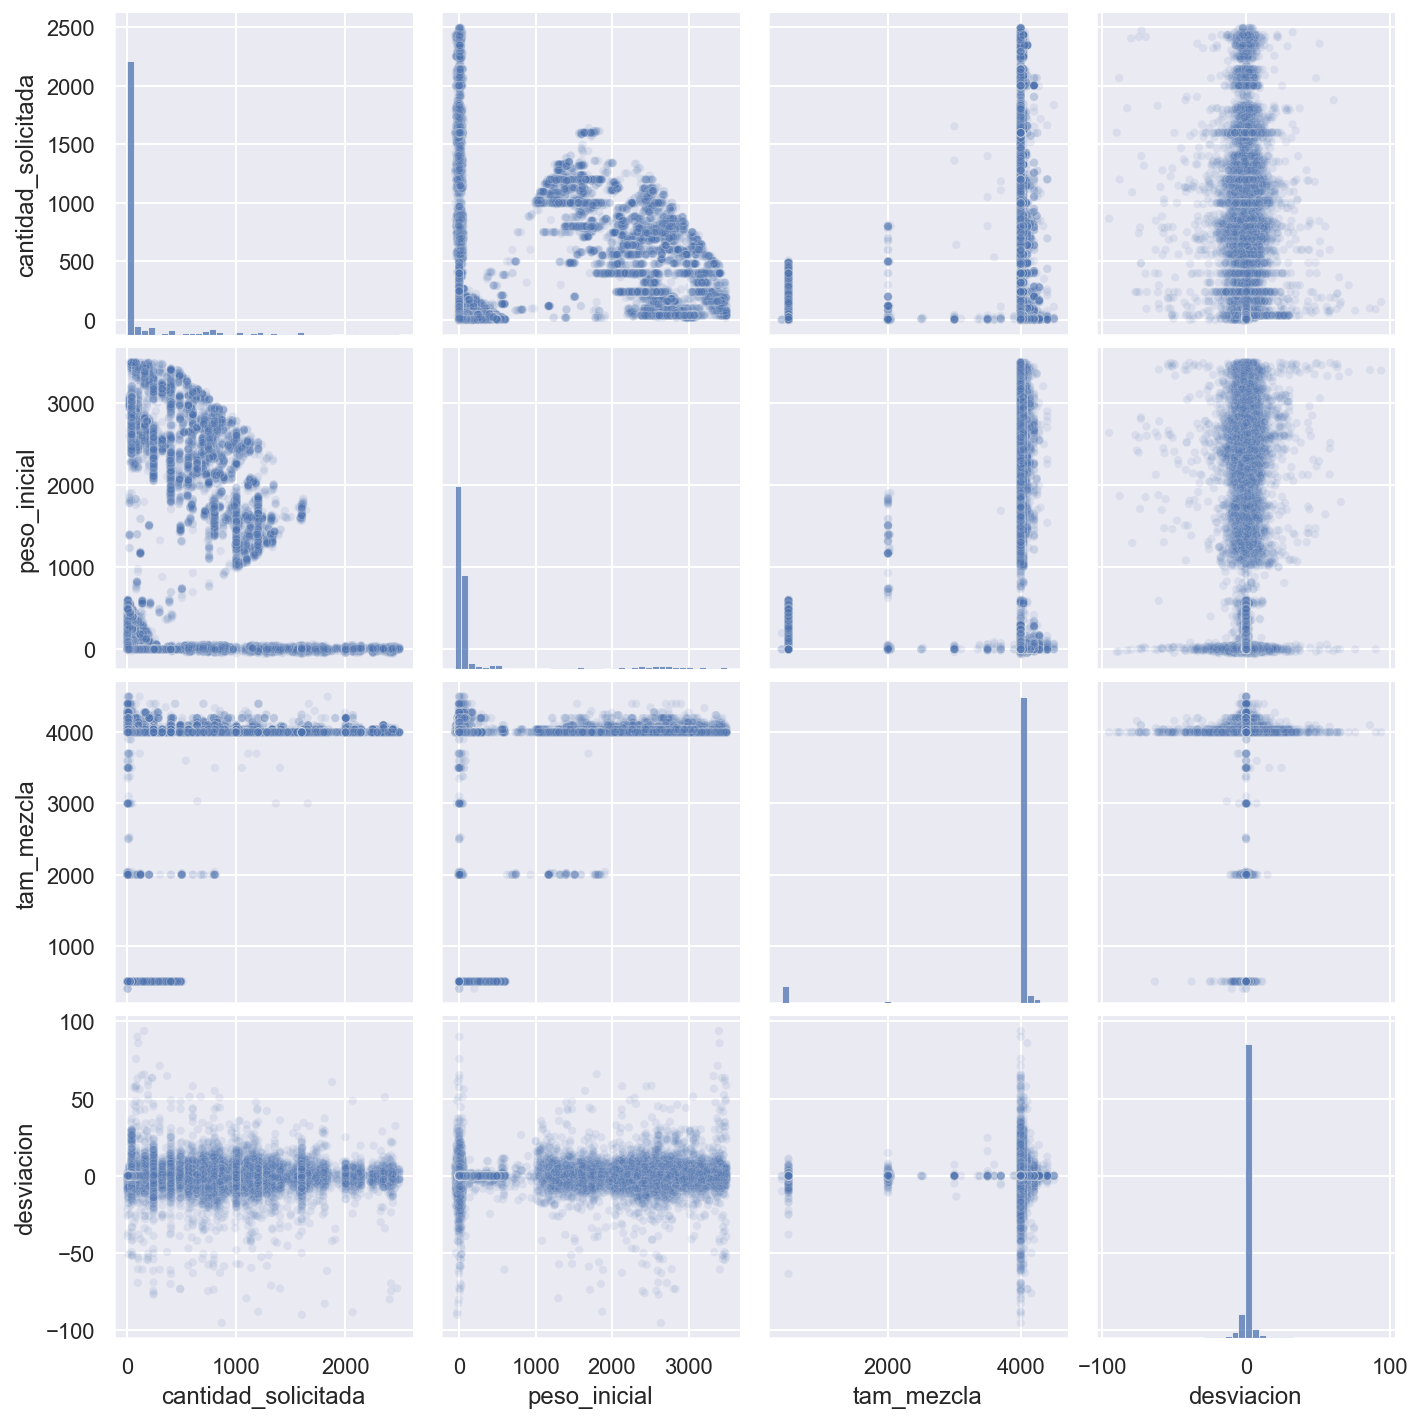

In [38]:
# Columnas relativas a la valoración
var_numericas = ['cantidad_solicitada','peso_inicial', 'tam_mezcla', 'desviacion']

# COMPLETAR
pg = sns.pairplot(df_dosificaciones.sample(n=100000), vars=var_numericas,  \
                  plot_kws={'alpha':0.1,'size':.1}, \
                  diag_kws={'bins':40})

In [33]:
df_month_pi_des = df_dosificaciones.groupby(['materia_origen','id_silo']).mean()[['peso_inicial','desviacion']]
df_month_pi_des.head()

peso_inicial  desviacion
materia_origen id_silo                          
1              9          314.503552   -0.154773
2              9          405.686760   -0.119901
3              28          13.530282    0.001634
               33          75.893939   -0.012918
               34          12.402381    0.006332

<AxesSubplot:xlabel='peso_inicial', ylabel='desviacion'>

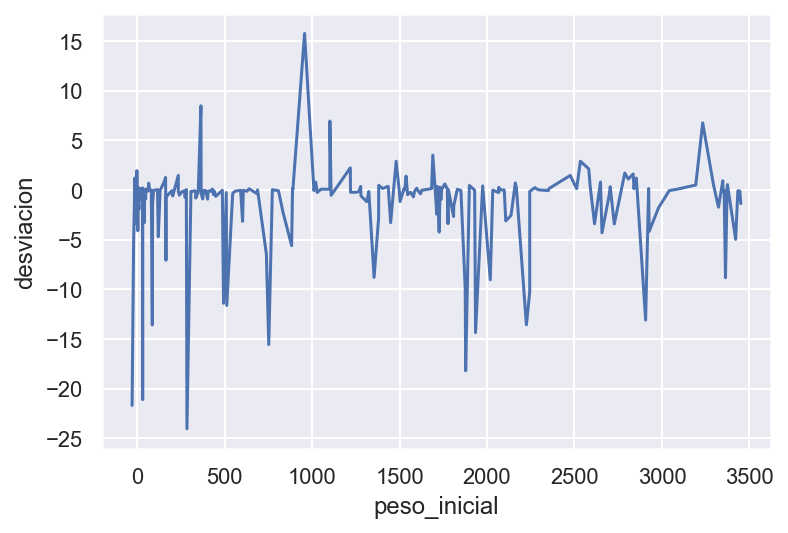

In [34]:
sns.lineplot(data=df_month_pi_des, x='peso_inicial', y='desviacion')

In [29]:
#!pip install sklearn

In [41]:
df_dosificaciones.to_csv('datos/data_clean.csv')

In [32]:
df_dos_sample = df_dosificaciones.sample(n=200000)

In [33]:
df_dos_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 69687 to 1041895
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   cantidad_solicitada  200000 non-null  float64
 1   peso_inicial         200000 non-null  float64
 2   materia_origen       200000 non-null  int64  
 3   materia_destino      200000 non-null  int64  
 4   id_silo              200000 non-null  int64  
 5   tam_mezcla           200000 non-null  int64  
 6   desviacion           200000 non-null  float64
 7   mes                  200000 non-null  int64  
 8   dia                  200000 non-null  int64  
 9   hora                 200000 non-null  int64  
 10  dow                  200000 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 18.3 MB


In [35]:
len(X_train)

134000

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_features = ['materia_origen', 'materia_destino', 'id_silo', 'mes', 'dia', 'hora', 'dow']
num_features = ['cantidad_solicitada','peso_inicial','tam_mezcla']

num_transformer = Pipeline([('imputer',SimpleImputer()),
                            ('standard_scaler', StandardScaler())])

cat_transformer = Pipeline([('simple_imputer', SimpleImputer(strategy='constant')),
                            ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])

column_trans = ColumnTransformer(
                transformers=[
                    ('num',num_transformer,num_features),
                    ('cat',cat_transformer,cat_features)])


In [44]:
from sklearn.model_selection import train_test_split

X = df_dosificaciones.drop('desviacion',1)
y = df_dosificaciones['desviacion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

/Users/jlcasado/MCIDAEN/mc1-tfm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
X_train_prep = column_trans.fit_transform(X_train)
X_test_prep  = column_trans.transform(X_test)

In [46]:
from sklearn.linear_model import LinearRegression

linr_model = LinearRegression()

linr_model.fit(X_train_prep, y_train)

LinearRegression()

In [51]:
from sklearn.metrics import mean_squared_error

y_pred = linr_model.predict(X_train_prep)
y_pred_test = linr_model.predict(X_test_prep)

print("Linear regression")
print("Error de entrenamiento: ", mean_squared_error(y_train, y_pred))
print("Error de test: ", mean_squared_error(y_test, y_pred_test))

Linear regression
Error de entrenamiento:  11.623373983850598
Error de test:  11.877618831629924


In [42]:
for col in df_dos_sample:
    print(col + ": " + str(df_dosificaciones[col].nunique()))
    if (df_dosificaciones[col].nunique() < 200):
        print(df_dosificaciones[col].unique())

cantidad_solicitada: 52800
peso_inicial: 118806
materia_origen: 64
[ 13  16  51  22  12   5  20  54  24   6   3  23  21  11  57  40  10  28
  55  27   2  18  36   8  14   9  52  91  17   4  15   1  43  34  31  32
  33  38  42  44  47  92  93  95  19  45 103  98 104  89 113  90   7 166
 167 178 188 189  87 202 176 171 305 438]
materia_destino: 162
[ 66  58  68  56  67  60  64  61  63  53  72  29  70  25  78  49  80  39
  71  26  75  41  81  50  73  30  76  46  48  77  97  96  74  35  79  37
  65  62  69  59 108 107 110 109 115 114 121 120 119 118 123 122 125 124
 116 127 126 133 132 169 168 179 180 182 181 187 186 193 192 106 195 199
 198 191 190 206 205 208 207 196 213 212 216 215 218 217 221 220 222 223
 226 225 230 229 242 241 245 244 248 247 250 249 173 172 252 251 265 264
 273 272 279 278 281 280 286 285 292 291 295 294 298 297 300 299 301 302
 304 303 307 306 309 308 311 310 313 312 320 319 324 323 322 321 318 317
 315 314 445 444 456 455 470 469 473 472 479 478 481 483 485 484 49

In [53]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

lr_model = Ridge();

churn_pipe_lr = Pipeline([('prep', column_trans),
                            ('clas', lr_model)])

In [60]:
parameters = {}
parameters['prep__num__imputer__strategy'] = ['mean', 'median']
parameters['clas__alpha'] = [1,0.1,0.01,0.001,0.0001,0]

X_sample = X_train.sample(n=200000)
y_sample = y_train[X_sample.index]

GS = GridSearchCV(estimator=churn_pipe_lr, param_grid=parameters, scoring='neg_mean_squared_error', cv=5)
GS = GS.fit(X_sample, y_sample)	
    
print("Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)


Mejor score:  -12.201113251154016
Mejore configuración de parámetros:  {'clas__alpha': 1, 'prep__num__imputer__strategy': 'mean'}


In [47]:
X_all = df_dosificaciones.drop('desviacion',1)
y_all = df_dosificaciones['desviacion']

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.33, random_state=0)

len(X_train)

/Users/jlcasado/MCIDAEN/mc1-tfm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


1396442

In [64]:
ridge_model = Ridge(alpha=0.1);

ridge_model.fit(X_train_prep, y_train) 

Ridge(alpha=0.1)

In [65]:
y_pred = ridge_model.predict(X_train_prep)
y_pred_test = ridge_model.predict(X_test_prep)

print("Error de entrenamiento: ", mean_squared_error(y_train, y_pred))
print("Error de test: ", mean_squared_error(y_test, y_pred_test))

Error de entrenamiento:  11.623416974930063
Error de test:  11.877663718625596


In [49]:
import pickle
nombre_modelo = 'modelo_ridge.pkl'

pickle.dump(churn_pipe_logr, open(nombre_modelo,'wb'))

In [50]:
loaded_model = pickle.load(open(nombre_modelo, 'rb'))

In [51]:
y_pred = loaded_model.predict(X_test)

In [52]:
print("Ridge")
print("Error de entrenamiento: ", mean_squared_error(y_test, y_pred))

Ridge
Error de entrenamiento:  11.413147639281906


In [81]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

from sklearn.ensemble import RandomForestRegressor

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('prep', column_trans),
                ('modelo',  RandomForestRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [50, 100, 200, 1000],
    'modelo__max_features': ["auto", 3, 5, 7],
    'modelo__max_depth'   : [None, 3, 5, 10, 20]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

In [82]:
X_sample = X_train.sample(n=2000)
y_sample = y_train[X_sample.index]

In [94]:
grid.fit(X = X_sample, y = y_sample)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = True)\
    .head(1)

,param_modelo__n_estimators,param_modelo__max_features,param_modelo__max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
0,50,auto,20,-3.737941,0.656663,-1.602172,0.069205


In [97]:
print("Mejor score: ", grid.best_score_)
print("Mejore configuración de parámetros: ", grid.best_params_)


Mejor score:  -3.424919299009838
Mejore configuración de parámetros:  {'modelo__n_estimators': 1000, 'modelo__max_features': 7, 'modelo__max_depth': 3}


In [96]:
rf_model = RandomForestRegressor(n_estimators=1000,max_features=7,max_depth=3)

rf_model.fit(X_train_prep, y_train)

RandomForestRegressor(max_depth=3, max_features=7, n_estimators=1000)

In [98]:
y_pred = rf_model.predict(X_train_prep)
y_pred_test = rf_model.predict(X_test_prep)

print("Error de entrenamiento: ", mean_squared_error(y_train, y_pred))
print("Error de test: ", mean_squared_error(y_test, y_pred_test))

Error de entrenamiento:  11.734173725994342
Error de test:  11.996220816005833
